# Fixing the ORCA longitude for plotting with Cartopy

## Download some example data

(Only necessary once.)

In [1]:
# !curl -O https://zenodo.org/record/3755721/files/FOCI1.14-TEST.2020.04.1_1m_20120101_20121231_grid_T.nc

## Relevant imports

In [2]:
import cartopy
import cmocean
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr

## Open dataset, add x,y coords, and extract single time step of SST

In [3]:
ds = xr.open_dataset(
    "FOCI1.14-TEST.2020.04.1_1m_20120101_20121231_grid_T.nc",
).isel(
    time_counter=-1, drop=True
)

ds.coords["x"] = range(ds.dims["x"])
ds.coords["y"] = range(ds.dims["y"])

sst = ds.sosstsst.rename("sst")
sst = sst.where(sst != 0)

display(sst)

<xarray.DataArray 'sst' (y: 511, x: 722)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    nav_lat  (y, x) float32 -77.010475 -77.010475 ... 49.995502 49.995502
    nav_lon  (y, x) float32 72.75 73.25 73.75 ... 73.00986 73.000015 72.999985
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 713 714 715 716 717 718 719 720 721
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 502 503 504 505 506 507 508 509 510
Attributes:
    standard_name:       sea_surface_temperature
    long_name:           sea surface temperature
    units:               degC
    online_operation:    average
    interval_operation:  1800 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 1800 s)

## Get rid of discontinuity on lon grid

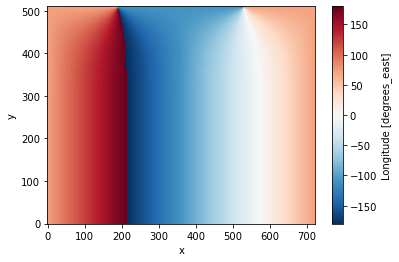

In [4]:
sst.coords["nav_lon"].plot()

Let's add 360 to the right of the discontinuity. So we'll use some boolean gymnastics to create a mask for this part:

In [5]:
after_discont = ~(
    sst.coords["nav_lon"].diff("x", label="upper") > 0
).cumprod("x").astype(bool)

In [14]:
sst.coords["nav_lon"].max()

<xarray.DataArray 'nav_lon' ()>
array(432.99998474)

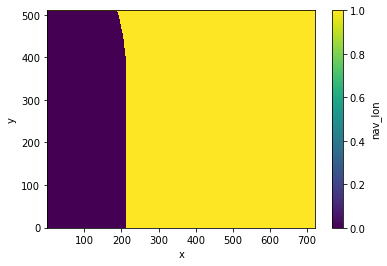

In [6]:
after_discont.plot()

And add 360 degrees there. Note that this is where we need the x coordinate we've introduced just after loading the dataset, because `.diff("x")` results in an array that is one shorter in the x direction than the original array. Hence, `after_discontinuity` is shaped differently than `sst`. With explicit x coord, xarray can still align both:

In [7]:
sst.coords["nav_lon"] = (
    sst.coords["nav_lon"]
    + 360 * after_discont
)

## Crop to non-redundant part of the mesh

Note that here, we'll drop the upper slice in y. There may me grids which have more than one redundant slice at the upper boundary.

In [8]:
sst = sst.isel(x=slice(1, -1), y=slice(None, -1))

## Have a look at the final data

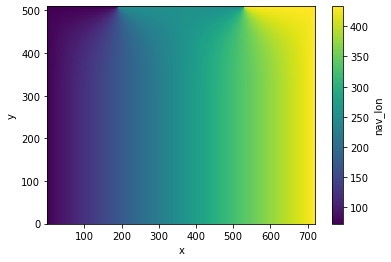

In [9]:
sst.coords["nav_lon"].plot();

### No projection

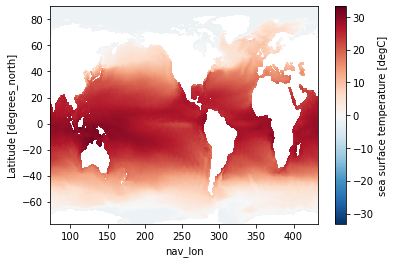

In [10]:
sst.plot.pcolormesh(
    x="nav_lon", y="nav_lat",
);

### With projection: Shading

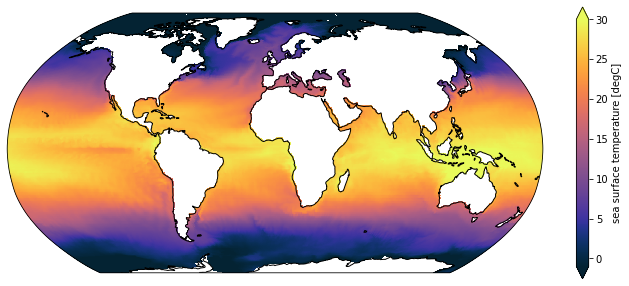

In [11]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw=dict(projection=cartopy.crs.Robinson()),
    figsize=(12, 5)
)
p = sst.plot.pcolormesh(
    x="nav_lon", y="nav_lat",
    ax=ax,
    transform=cartopy.crs.PlateCarree(),
    cmap=cmocean.cm.thermal,
    vmin=-1, vmax=30
)

ax.coastlines();

### With projection: Contour lines

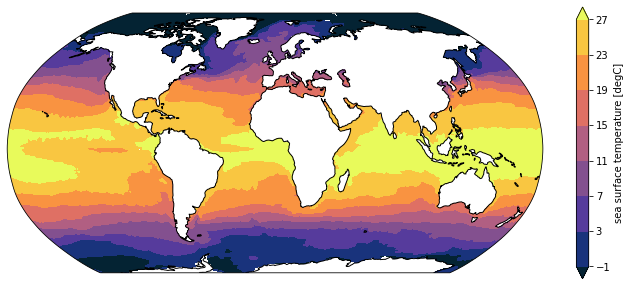

In [12]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw=dict(projection=cartopy.crs.Robinson()),
    figsize=(12, 5)
)
p = sst.plot.contourf(
    x="nav_lon", y="nav_lat",
    ax=ax,
    transform=cartopy.crs.PlateCarree(),
    cmap=cmocean.cm.thermal,
    levels=np.arange(-1, 30, 4)
)

ax.coastlines();